# Uplift Tree Visualization

## Introduction
This example notebooks illustrates how to visualize uplift trees for interpretation and diagnosis. 

#### Supported Models
These visualization functions work only for tree-based algorithms:

- Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
- Uplift tree/random forests on Contextual Treatment Selection

Currently, they are NOT supporting Meta-learner algorithms

- S-learner
- T-learner
- X-learner
- R-learner

#### Supported Usage
This notebook will show how to use visualization for:

- Uplift Tree and Uplift Random Forest
    - Visualize a trained uplift classification tree model
    - Visualize an uplift tree in a trained uplift random forests

- Training and Validation Data
    - Visualize the validation tree: fill the trained uplift classification tree with validation (or testing) data, and show the statistics for both training data and validation data
    
- One Treatment Group and Multiple Treatment Groups
    - Visualize the case where there are one control group and one treatment group
    - Visualize the case where there are one control group and multiple treatment groups



## Step 1 Load Modules

### Load CausalML modules

In [19]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_dotgraph

### Load standard modules

In [20]:
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split
import pydotplus

## One Control + One Treatment for Uplift Classification Tree 

In [21]:
# Data generation
df, x_names = make_uplift_classification()

df.head()

df = df[df['treatment_group_key'].isin(['control','treatment1'])]

# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.5110,1000
treatment1,0.5140,1000
All,0.5125,2000


In [22]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 5, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [23]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

x18_uplift_increase >= -1.3039248112755226?
yes -> x1_informative >= -0.8277030695336565?
		yes -> x7_irrelevant >= -0.5541554186274725?
				yes -> x19_increase_mix >= -0.782381242022013?
						yes -> {'treatment1': 0.526316, 'control': 0.541667}
						no  -> {'treatment1': 0.618644, 'control': 0.43609}
				no  -> {'treatment1': 0.503067, 'control': 0.5}
		no  -> {'treatment1': 0.438017, 'control': 0.548148}
no  -> {'treatment1': 0.413174, 'control': 0.529412}


#### Read the tree
- First line: node split condition
- impurity: the value for the loss function
- total_sample: total sample size in this node
- group_sample: sample size by treatment group
- uplift score: the treatment effect between treatment and control (when there are multiple treatment groups, this is the maximum of the treatment effects)
- uplift p_value: the p_value for the treatment effect
- validation uplift score: when validation data is filled in the tree, this reflects the uplift score based on the - validation data. It can be compared with the uplift score (for training data) to check if there are over-fitting issue.

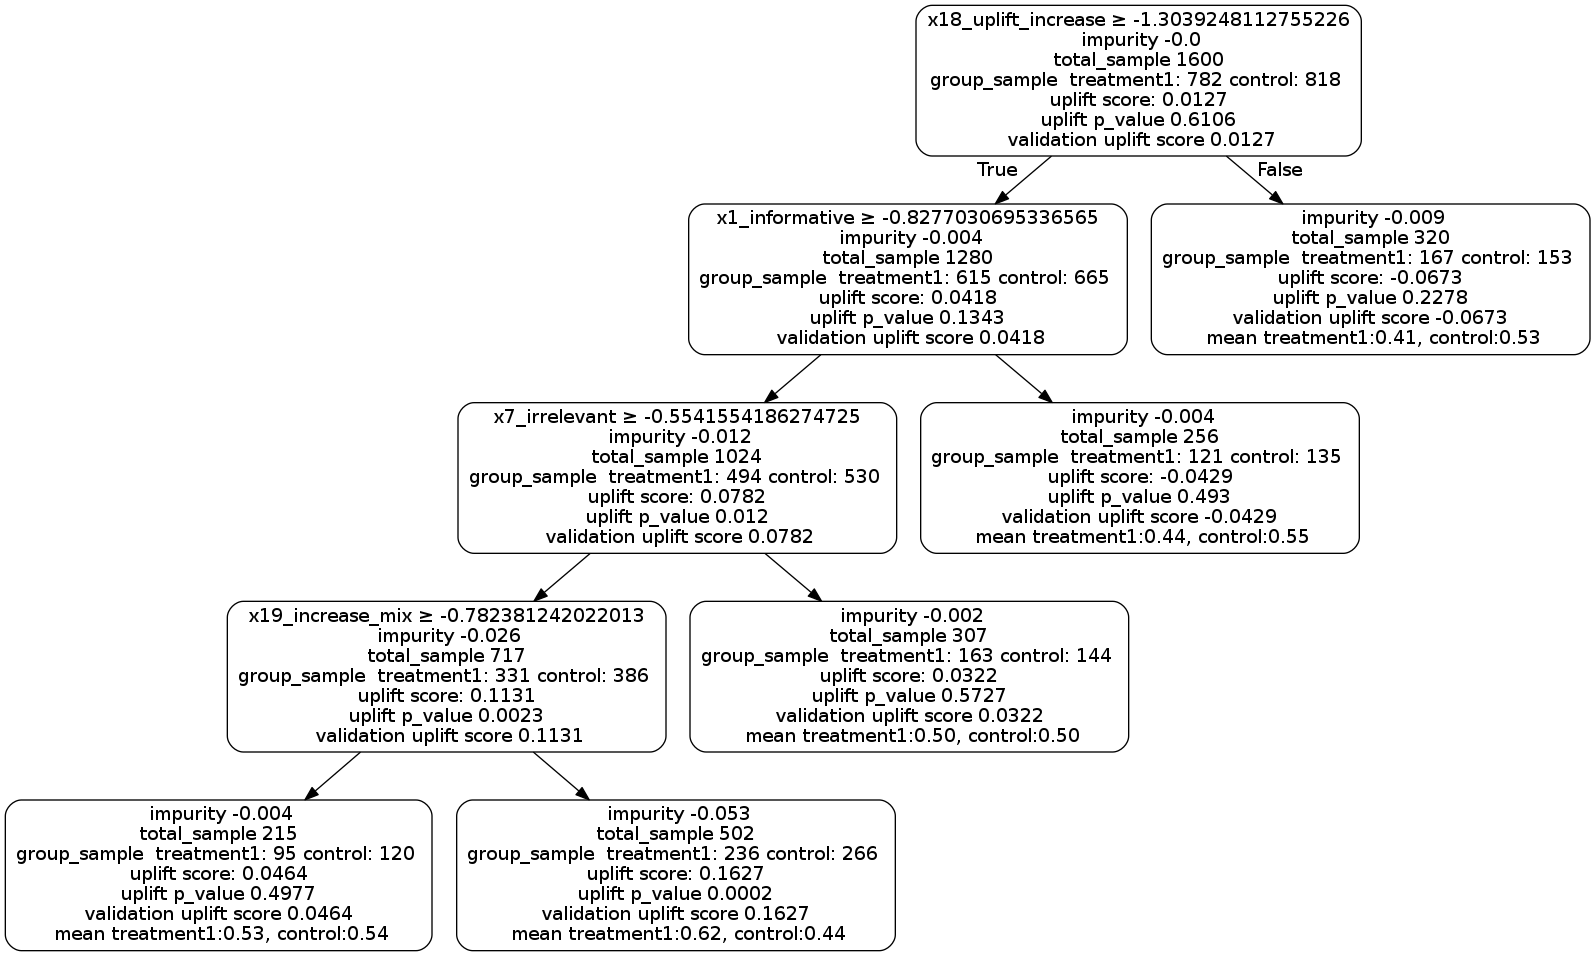

In [24]:
# Plot uplift tree
dot_data = uplift_tree_dotgraph(uplift_model.fitted_uplift_tree,x_names)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### Visualize Validation Tree: One Control + One Treatment for Uplift Classification Tree
Note the validation uplift score will update.

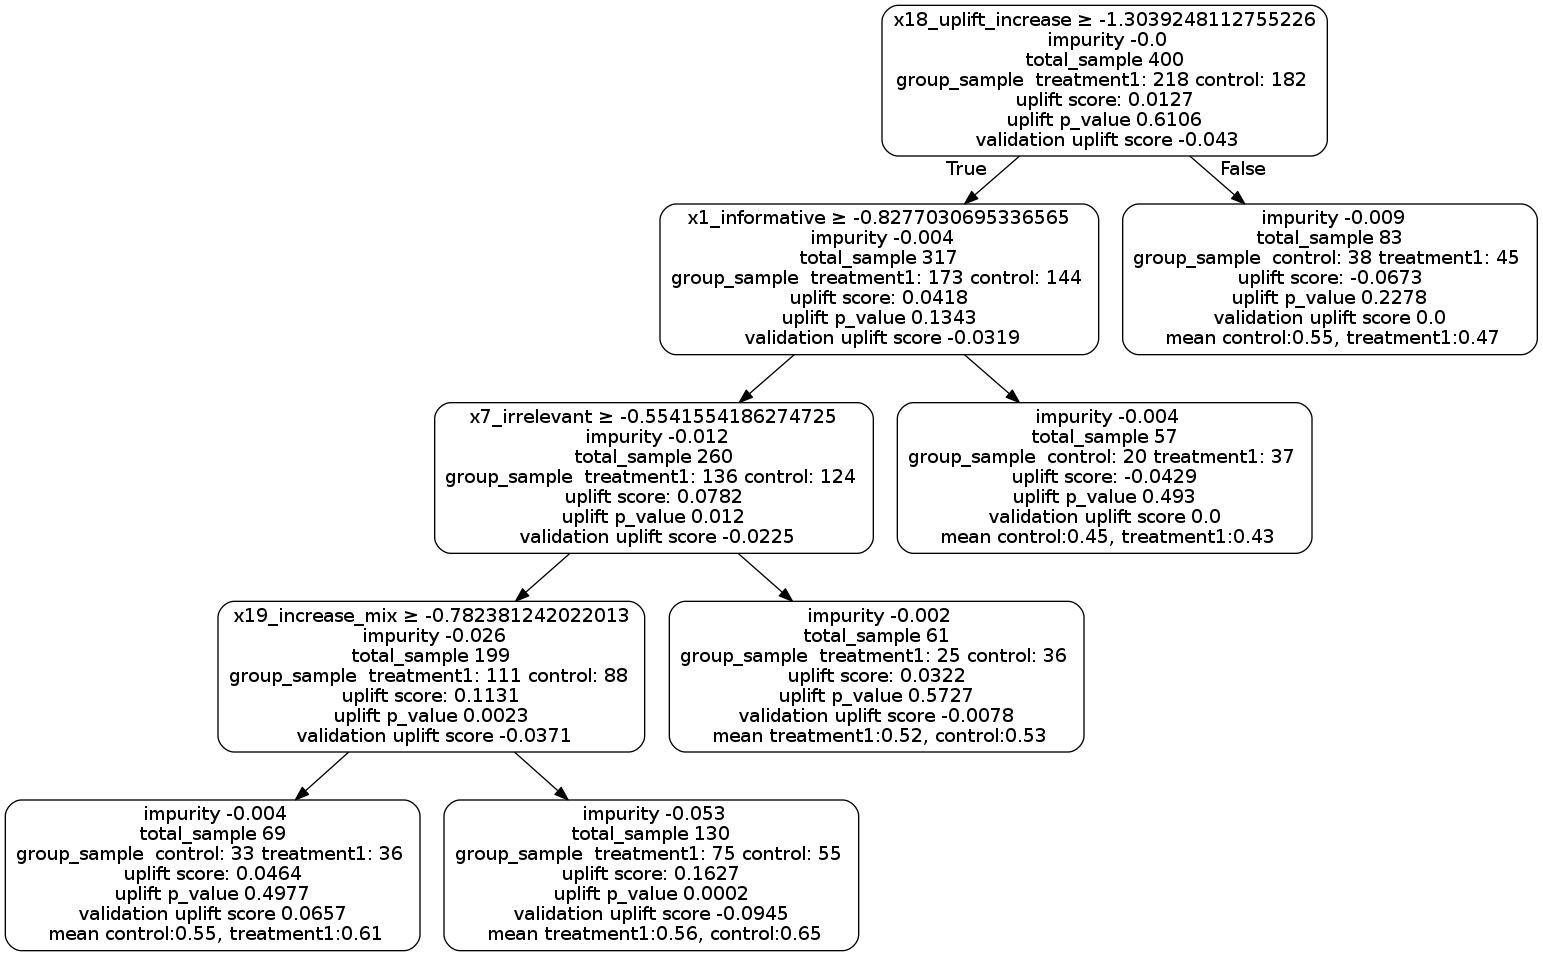

In [25]:
### Fill the trained tree with testing data set 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_model.fill(X=df_test[x_names].values, treatment=df_test['treatment_group_key'].values, y=df_test['conversion'].values)

# Plot uplift tree
dot_data = uplift_tree_dotgraph(uplift_model.fitted_uplift_tree,x_names)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### Visualize a Tree in Random Forest

In [26]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftRandomForestClassifier(n_estimators=5, max_depth = 5, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [28]:
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model.uplift_forest[0]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names)

x16_increase_mix >= 1.0842809969006826?
yes -> x7_irrelevant >= 0.06177540756557202?
		yes -> {'control': 0.357143, 'treatment1': 0.596899}
		no  -> {'treatment1': 0.546875, 'control': 0.387387}
no  -> x12_uplift_increase >= -0.02034088060341288?
		yes -> {'control': 0.439252, 'treatment1': 0.697479}
		no  -> x18_uplift_increase >= -0.478451770923653?
				yes -> {'control': 0.440559, 'treatment1': 0.507937}
				no  -> x16_increase_mix >= 0.5291311366785828?
						yes -> {'control': 0.626582, 'treatment1': 0.333333}
						no  -> {'treatment1': 0.437037, 'control': 0.494318}


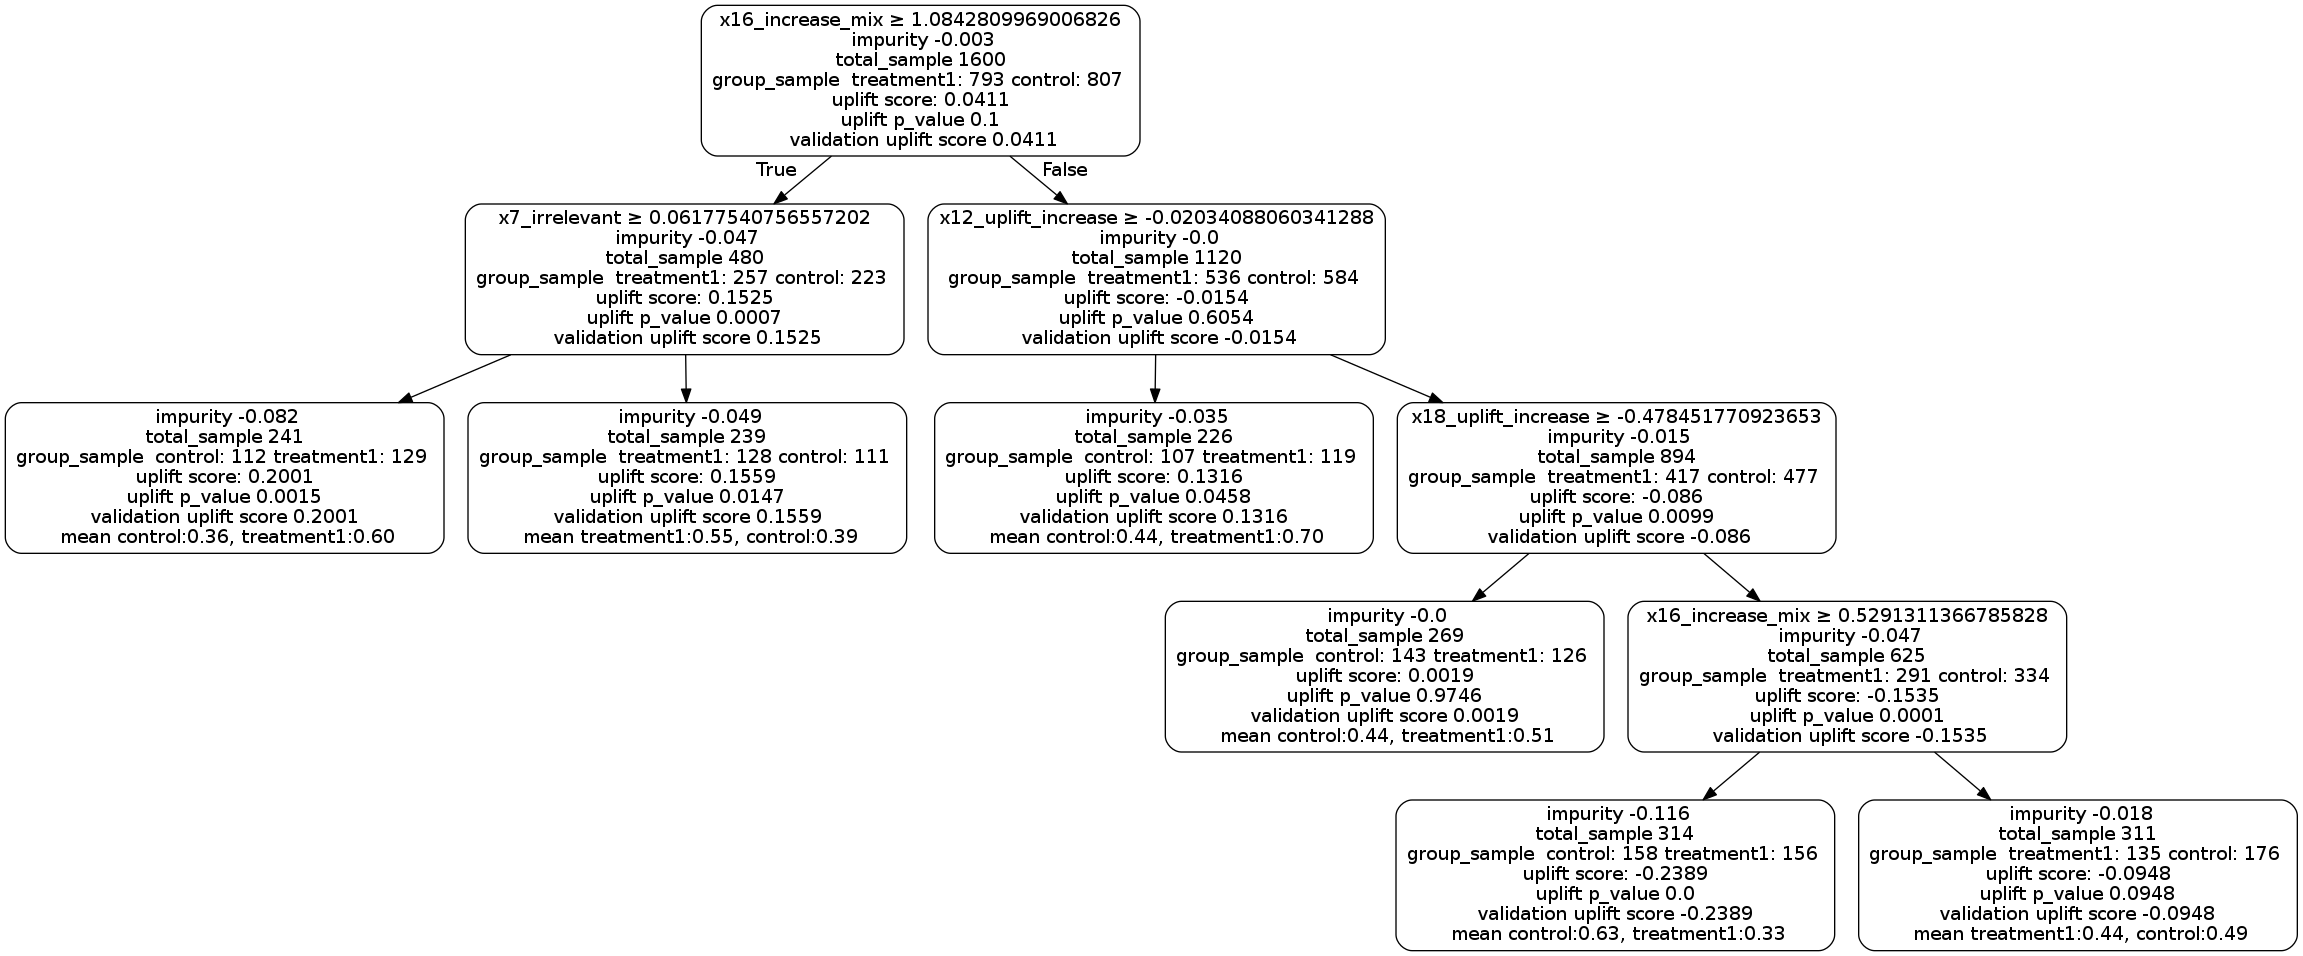

In [29]:
# Plot uplift tree
dot_data = uplift_tree_dotgraph(uplift_tree.fitted_uplift_tree,x_names)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#### Fill the tree with validation data

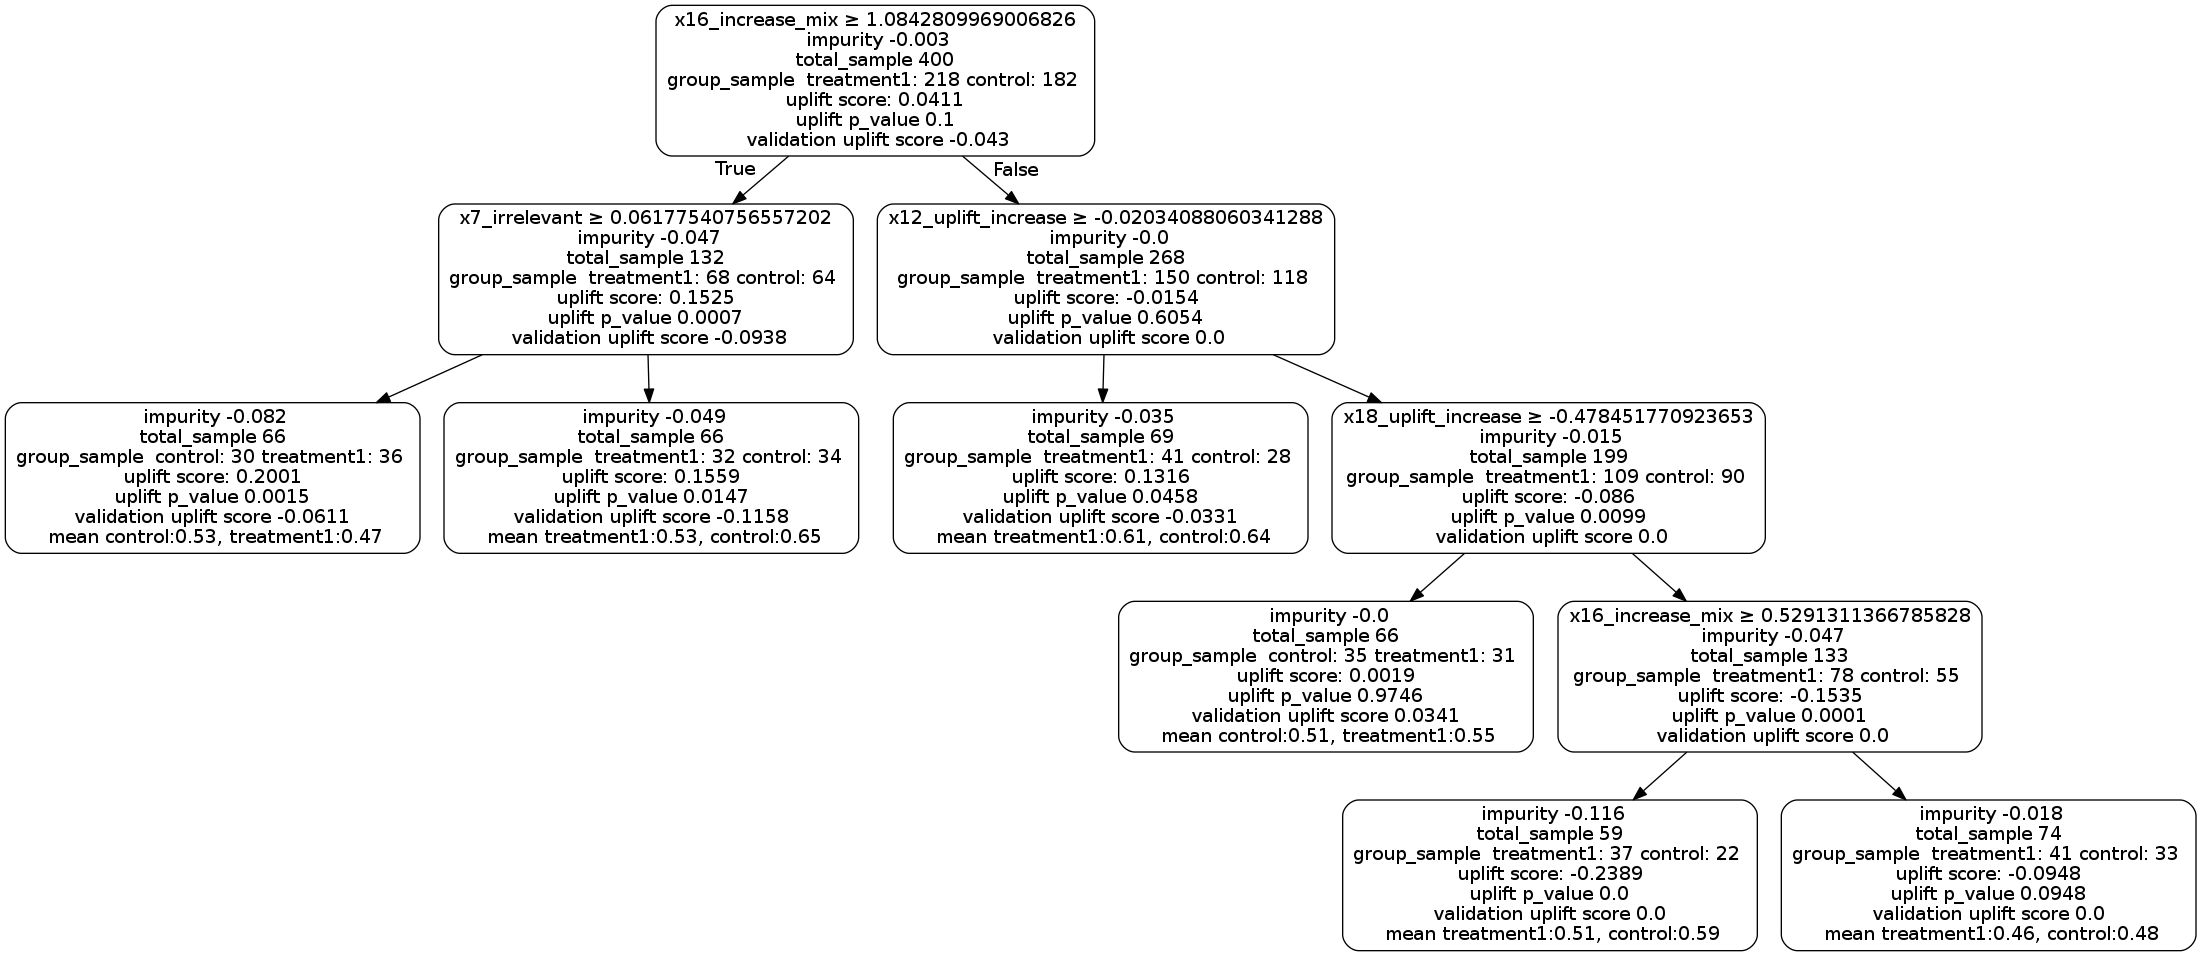

In [31]:
### Fill the trained tree with testing data set 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_tree.fill(X=df_test[x_names].values, treatment=df_test['treatment_group_key'].values, y=df_test['conversion'].values)

# Plot uplift tree
dot_data = uplift_tree_dotgraph(uplift_tree.fitted_uplift_tree,x_names)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## One Control + Multiple Treatments

In [8]:
# Data generation
df, x_names = make_uplift_classification()
# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


In [9]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 3, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

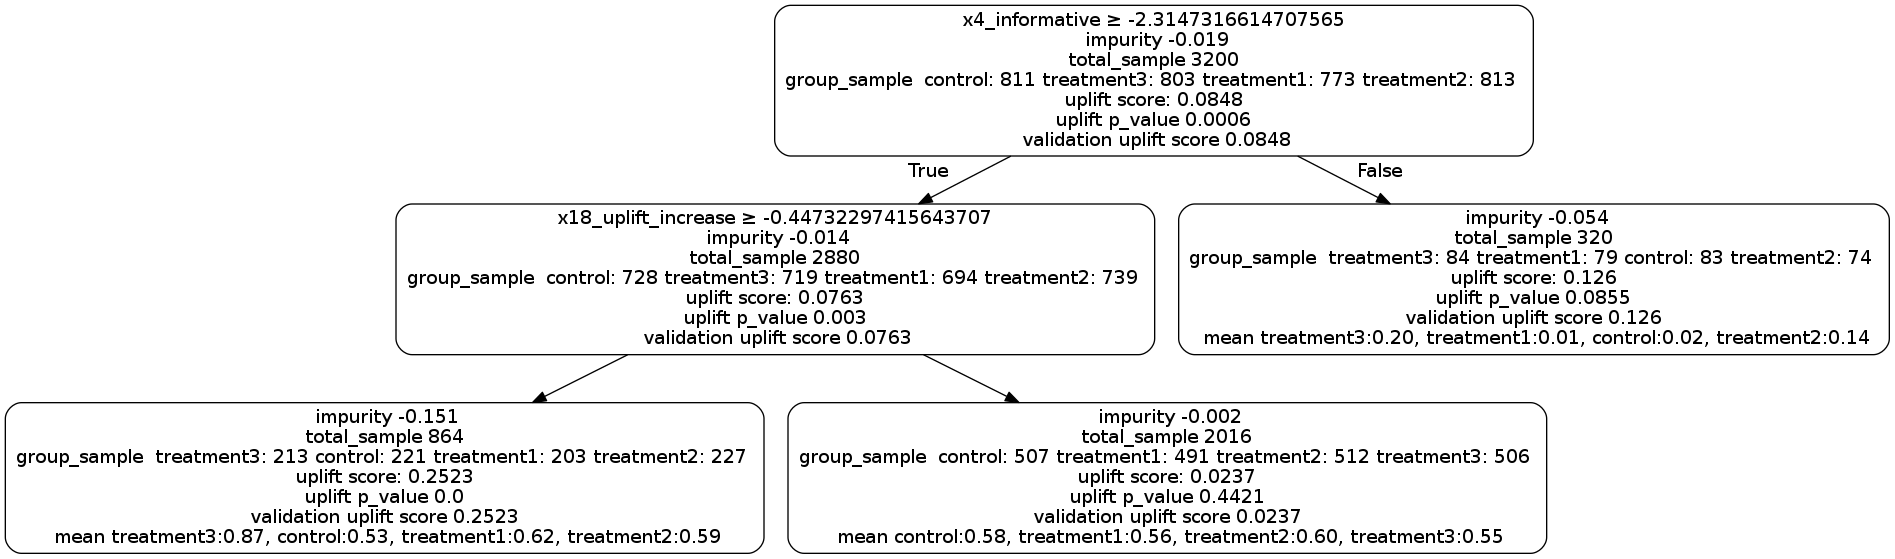

In [10]:
# Plot uplift tree
# The uplift score represents the best uplift score among all treatment effects
dot_data = uplift_tree_dotgraph(uplift_model.fitted_uplift_tree,x_names)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### Save the Plot

In [32]:
# Save the graph as pdf
graph.write_pdf("tbc.pdf")
# Save the graph as png
graph.write_png("tbc.png")

True